## CS504 Fall 2021 Project 4

### Group 34 
Prashanth Paul Dasari | Lavanya Kumaran | Anushree Manoharrao


### Loading packages

In [6]:
import pandas as pd
from sklearn import tree
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import os
import io
from IPython.display import Image  
from six import StringIO  
import pydotplus
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import KFold,cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_selection import SelectKBest
import seaborn as sns
from plotnine import ggplot, aes, geom_bar, geom_col, geom_point
import plotnine as p9

### Loading the dataset

In [7]:
df_banks = pd.read_csv("data/bank.csv", delimiter=";")

In [8]:
df_banks

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


In [9]:
#df_banks["pdays_not_contacted"] = df_banks.pdays == -1
#df_banks.pdays = df_banks.pdays.replace({-1:900})
#df_banks = df_banks.drop(columns=["day"])

### Preprocessing

In [10]:
df_banks.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [11]:
df_banks.job.unique()

array(['unemployed', 'services', 'management', 'blue-collar',
       'self-employed', 'technician', 'entrepreneur', 'admin.', 'student',
       'housemaid', 'retired', 'unknown'], dtype=object)

In [12]:
df_banks.month.unique()

array(['oct', 'may', 'apr', 'jun', 'feb', 'aug', 'jan', 'jul', 'nov',
       'sep', 'mar', 'dec'], dtype=object)

#### Exploratory data analysis

In [13]:
df_banks.y.value_counts()

no     4000
yes     521
Name: y, dtype: int64

Text(0.5, 1.0, 'Distribution of output variable')

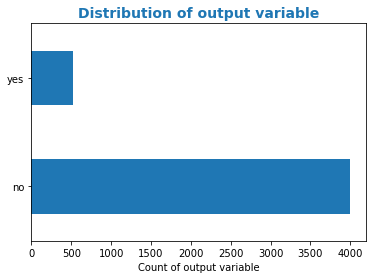

In [14]:
df_banks.y.value_counts().plot.barh()
plt.xlabel('Count of output variable', fontsize=10)
plt.title('Distribution of output variable', fontsize=14, weight='bold', color='tab:blue')

In [15]:
df_banks.marital.unique()

array(['married', 'single', 'divorced'], dtype=object)

Text(0.5, 1.0, 'Distribution of marital status')

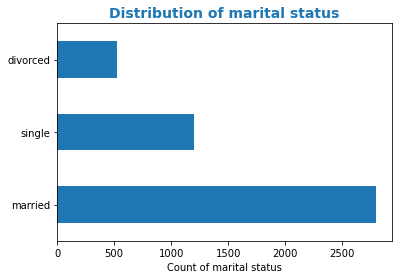

In [16]:
df_banks.marital.value_counts().plot.barh()
plt.xlabel('Count of marital status', fontsize=10)
plt.title('Distribution of marital status', fontsize=14, weight='bold', color='tab:blue')

In [17]:
df_banks['loan'].value_counts().sort_index()

no     3830
yes     691
Name: loan, dtype: int64

In [18]:
df_banks['housing'].value_counts().sort_index()

no     1962
yes    2559
Name: housing, dtype: int64

In [19]:
df_plot_loans = (df_banks[["housing", "loan"]]
                 .rename(columns={"loan":"personal"})
                 .melt(var_name="loan_type", value_name="is_loan"))

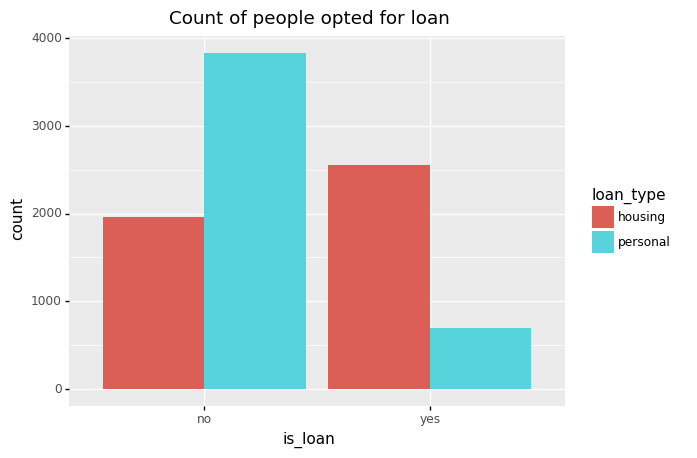

<ggplot: (156142793421)>

In [20]:
(ggplot(aes("is_loan", fill="loan_type"), data=df_plot_loans) +
 geom_bar(position="dodge") +
 labs(title="Count of people opted for loan"))

[Text(0.5, 1.0, 'Distribution of age')]

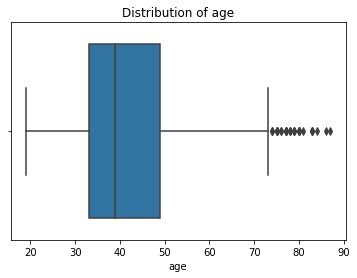

In [21]:
sns.boxplot(x=df_banks['age']).set(title='Distribution of age')

[Text(0.5, 1.0, 'Outcome of the previous marketing campaignt Vs no of present campaigns')]

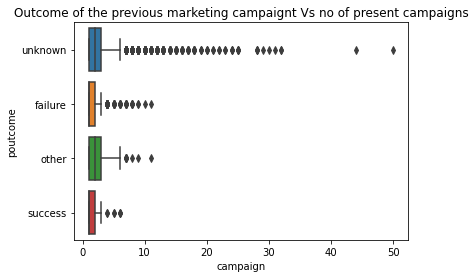

In [22]:
sns.boxplot(data=df_banks, x='campaign', y='poutcome').set(title='Outcome of the previous marketing campaignt Vs no of present campaigns')

[Text(0.5, 1.0, 'Output variable "y" Vs no of present campaigns')]

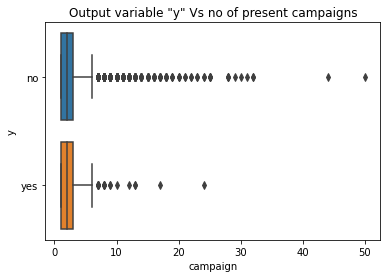

In [23]:
sns.boxplot(data=df_banks, x='campaign', y='y').set(title='Output variable "y" Vs no of present campaigns')

In [24]:
d = {'yes': 1, 'no': 0}
df_banks['default'] = df_banks['default'].map(d)
df_banks['housing'] = df_banks['housing'].map(d)
df_banks['loan'] = df_banks['loan'].map(d)
df_banks['y'] = df_banks['y'].map(d)

p = {'primary': 0, 'secondary': 1, 'tertiary': 2, "unknown":3}
df_banks['education'] = df_banks['education'].map(p)
m = {'single': 0, 'married': 1, 'divorced': 2}
df_banks['marital'] = df_banks['marital'].map(m)
j = {'unemployed':0, 'services':1, 'management':2, 'blue-collar':3,
       'self-employed':4, 'technician':5, 'entrepreneur':6, 'admin.':7, 'student':8,
       'housemaid':9, 'retired':10, 'unknown':11}
df_banks['job'] = df_banks['job'].map(j)
month = {'oct':10, 'may':5, 'apr':4, 'jun':6, 'feb':2, 'aug':8, 'jan':1, 'jul':7, 'nov':11,
       'sep':9, 'mar':3, 'dec':12}
df_banks['month'] = df_banks['month'].map(month)
d = {'cellular': 0, 'unknown': 1, 'telephone': 2}
df_banks['contact'] = df_banks['contact'].map(d)
d = {'unknown': 0, 'failure': 1, 'other': 2, 'success' : 3}
df_banks['poutcome'] = df_banks['poutcome'].map(d)
df_banks.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,0,1,0,0,1787,0,0,0,19,10,79,1,-1,0,0,0
1,33,1,1,1,0,4789,1,1,0,11,5,220,1,339,4,1,0
2,35,2,0,2,0,1350,1,0,0,16,4,185,1,330,1,1,0
3,30,2,1,2,0,1476,1,1,1,3,6,199,4,-1,0,0,0
4,59,3,1,1,0,0,1,0,1,5,5,226,1,-1,0,0,0


In [25]:
cormat = df_banks.corr()
round(cormat,2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
age,1.00,0.25,0.38,-0.12,-0.02,0.08,-0.19,-0.01,0.12,-0.02,0.07,-0.00,-0.01,-0.01,-0.00,0.03,0.05
job,0.25,1.00,0.02,-0.09,-0.00,0.05,-0.16,0.00,0.02,0.00,0.03,-0.01,-0.04,0.00,0.02,0.05,0.07
marital,0.38,0.02,1.00,-0.10,0.02,-0.02,0.03,0.05,0.07,-0.01,0.05,-0.01,-0.01,-0.02,-0.04,-0.03,-0.02
education,-0.12,-0.09,-0.10,1.00,-0.01,0.06,-0.09,-0.05,-0.11,0.01,0.06,-0.01,-0.00,0.01,0.02,0.05,0.04
default,-0.02,-0.00,0.02,-0.01,1.00,-0.07,0.01,0.06,-0.01,-0.01,0.01,-0.01,-0.01,-0.03,-0.03,-0.03,0.00
balance,0.08,0.05,-0.02,0.06,-0.07,1.00,-0.05,-0.07,0.01,-0.01,0.10,-0.02,-0.01,0.01,0.03,0.03,0.02
housing,-0.19,-0.16,0.03,-0.09,0.01,-0.05,1.00,0.02,0.10,-0.03,-0.17,0.02,-0.00,0.12,0.04,0.01,-0.10
loan,-0.01,0.00,0.05,-0.05,0.06,-0.07,0.02,1.00,-0.01,-0.00,0.04,-0.00,0.02,-0.03,-0.02,-0.05,-0.07
contact,0.12,0.02,0.07,-0.11,-0.01,0.01,0.10,-0.01,1.00,0.01,-0.13,-0.02,0.03,-0.17,-0.12,-0.15,-0.08
day,-0.02,0.00,-0.01,0.01,-0.01,-0.01,-0.03,-0.00,0.01,1.00,0.08,-0.02,0.16,-0.09,-0.06,-0.06,-0.01


In [26]:
y_cors = np.absolute(cormat)["y"]
y_cors[y_cors>=0.1]

housing     0.104683
duration    0.401118
pdays       0.104087
previous    0.116714
poutcome    0.246566
y           1.000000
Name: y, dtype: float64

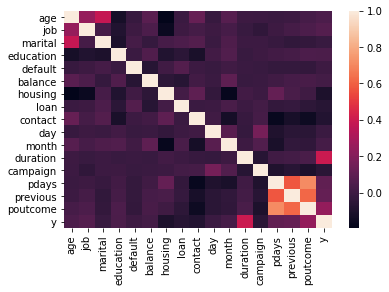

In [27]:
sns.heatmap(cormat);

In [28]:
#From the heat map, it is evident that the attribute 'housing' is least related to the output variable, 
#Housing is dropped from the dataframe
df_banks = df_banks.drop(columns=["housing"])

In [29]:
#decision trees
y = df_banks["y"]
X = df_banks.drop(columns="y")

#### Splitting train set and test set

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify = y, random_state = 200)
X_train

,age,job,marital,education,default,balance,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
1494,27,1,0,1,0,-124,0,0,18,7,217,1,-1,0,0
3298,27,5,0,2,0,808,0,0,15,5,578,1,364,1,2
2909,39,7,1,1,0,406,0,0,30,7,253,5,-1,0,0
3007,44,3,1,1,0,508,0,0,20,4,222,1,154,1,1
2496,46,2,0,2,0,593,0,0,29,1,190,3,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2269,27,1,0,1,0,0,0,1,7,5,388,7,-1,0,0
4379,41,3,1,0,0,1172,0,1,15,5,153,1,-1,0,0
1332,45,7,1,1,0,204,0,0,3,6,224,2,-1,0,0
1120,48,6,1,1,0,725,1,0,10,7,105,1,-1,0,0


In [31]:
print("shape of input - training set", X_train.shape)
print("shape of output - training set", y_train.shape)
print("shape of input - testing set", X_test.shape)
print("shape of output - testing set", y_test.shape)

shape of input - training set (3390, 15)
shape of output - training set (3390,)
shape of input - testing set (1131, 15)
shape of output - testing set (1131,)


In [32]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        4521 non-null   int64
 1   job        4521 non-null   int64
 2   marital    4521 non-null   int64
 3   education  4521 non-null   int64
 4   default    4521 non-null   int64
 5   balance    4521 non-null   int64
 6   loan       4521 non-null   int64
 7   contact    4521 non-null   int64
 8   day        4521 non-null   int64
 9   month      4521 non-null   int64
 10  duration   4521 non-null   int64
 11  campaign   4521 non-null   int64
 12  pdays      4521 non-null   int64
 13  previous   4521 non-null   int64
 14  poutcome   4521 non-null   int64
dtypes: int64(15)
memory usage: 529.9 KB


In [33]:
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

In [34]:
 trf_preproc = make_column_transformer(
    (MinMaxScaler(), make_column_selector(dtype_include=np.integer))
)

In [35]:
kfold = StratifiedKFold(n_splits=10, random_state=10, shuffle=True)

## Decision Tree

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. 
The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

In [36]:
clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(X_train, y_train)
y_pred_tree = clf_tree.predict(X_test)

In [37]:
print("Accuracy for single train test split for decision tree:",metrics.accuracy_score(y_test, y_pred_tree))
print(metrics.classification_report(y_test, y_pred_tree))

Accuracy for single train test split for decision tree: 0.8567639257294429
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      1001
           1       0.39      0.42      0.40       130

    accuracy                           0.86      1131
   macro avg       0.66      0.67      0.66      1131
weighted avg       0.86      0.86      0.86      1131



#### With 10 fold cross validation

In [38]:
cv_result = cross_val_score(clf_tree, X, y, cv = kfold, scoring = "accuracy")
print("Value for k from 1 to 10 : ",cv_result)
print("Mean Accuracy from 10 fold cross validation:", cv_result.mean())

Value for k from 1 to 10 :  [0.89403974 0.88716814 0.8539823  0.83185841 0.86061947 0.84292035
 0.84734513 0.86283186 0.8539823  0.87610619]
Mean Accuracy from 10 fold cross validation: 0.8610853894391373


## Random forest

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [39]:
clf_random =  RandomForestClassifier(n_estimators=10, 
                                     max_features=10,
                                     min_samples_split=2,
                                     criterion="entropy",
                                     random_state=10,
                                     n_jobs=-1)
clf_random = clf_random.fit(X_train,y_train)
y_pred_random = clf_random.predict(X_test)
print("Accuracy for random forest:",metrics.accuracy_score(y_test, y_pred_random))

Accuracy for random forest: 0.9027409372236959


#### With 10 fold cross validation

In [40]:
y_preds = cross_val_predict(clf_random, X, y, cv=kfold)
result = cross_val_score(clf_random, X, y, cv = kfold,scoring = "accuracy")
print("Value for k from 1 to 10 : ",result)
print("Mean Accuracy from 10 fold cross validation:",result.mean())

Value for k from 1 to 10 :  [0.89403974 0.9159292  0.90486726 0.8960177  0.89380531 0.90486726
 0.90486726 0.8960177  0.89823009 0.89823009]
Mean Accuracy from 10 fold cross validation: 0.9006871593506418


In [41]:
print(confusion_matrix(y, y_preds))

[[3901   99]
 [ 350  171]]


##### Random Forest performs better and has better accuracy when compared to the decision tree

### KNN

K nearest neighbor method is to find a predefined number of training samples closest in distance to the new point, and predict the label from these. 
The number of samples can be a user-defined constant (k-nearest neighbor learning), or vary based on the local density of points (radius-based neighbor learning).

In [42]:
knn = KNeighborsClassifier(n_neighbors=10)
knn = knn.fit(X_train,y_train)
pred_knn = knn.predict(X_test)
print("Accuracy for KNN at K =10:",metrics.accuracy_score(y_test, pred_knn))

Accuracy for KNN at K =10: 0.8885941644562334


In [43]:
print(confusion_matrix(y_test,pred_knn))

[[985  16]
 [110  20]]


#### With 10 fold cross validation

In [44]:
result = cross_val_score(knn, X, y, cv = kfold,scoring = "accuracy")
print("Value for k from 1 to 10 : ",result)
print("Mean Accuracy from 10 fold cross validation:",result.mean())

Value for k from 1 to 10 :  [0.86975717 0.89159292 0.88716814 0.87610619 0.87610619 0.8960177
 0.88495575 0.87389381 0.87389381 0.87831858]
Mean Accuracy from 10 fold cross validation: 0.8807810271738068


In [45]:
error_rate = []
for i in range(1,51):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))


print(error_rate)
print(min(error_rate))


[0.14677276746242263, 0.11936339522546419, 0.1361626878868258, 0.12024756852343059, 0.12024756852343059, 0.11936339522546419, 0.12643678160919541, 0.11759504862953139, 0.11494252873563218, 0.11140583554376658, 0.11494252873563218, 0.11405835543766578, 0.12024756852343059, 0.11140583554376658, 0.11229000884173299, 0.11140583554376658, 0.11052166224580018, 0.10786914235190097, 0.11140583554376658, 0.11140583554376658, 0.11229000884173299, 0.11052166224580018, 0.11140583554376658, 0.10875331564986737, 0.11140583554376658, 0.11229000884173299, 0.11140583554376658, 0.11317418213969938, 0.11494252873563218, 0.11229000884173299, 0.11229000884173299, 0.11052166224580018, 0.11229000884173299, 0.11317418213969938, 0.11405835543766578, 0.11405835543766578, 0.11405835543766578, 0.11671087533156499, 0.11494252873563218, 0.11405835543766578, 0.11405835543766578, 0.11494252873563218, 0.11494252873563218, 0.11405835543766578, 0.11494252873563218, 0.11229000884173299, 0.11405835543766578, 0.11494252873

In [46]:
accuracy = []
val = range(1,51)
for i in val:
    knn = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(knn, X, y, cv = kfold,scoring = "accuracy")
    accuracy.append((scores.mean()))
print(accuracy)


[0.8491506964386879, 0.8781246947586394, 0.8672874054972748, 0.876798726288851, 0.8712706831545841, 0.8796733673250111, 0.875473734591416, 0.8790116040555589, 0.877684658813417, 0.8807810271738068, 0.8794555470901951, 0.8834349176580906, 0.8816650061536657, 0.884319873410303, 0.8832131903338608, 0.8840981460860732, 0.8836542030514369, 0.8860883197561977, 0.8856458418800914, 0.8869732755084101, 0.8852033640039852, 0.8871940260602864, 0.8871935376741096, 0.8865307976323038, 0.8858670808181446, 0.8871940260602862, 0.8876360155502159, 0.8876365039363925, 0.8876365039363927, 0.8871945144464632, 0.8869727871222333, 0.8869732755084099, 0.8865303092461272, 0.8863095586942509, 0.8880789818124987, 0.8869737638945867, 0.8876374807087462, 0.887416241770693, 0.8869732755084099, 0.8863100470804275, 0.887194514446463, 0.8865317744046571, 0.8874167301568697, 0.8869742522807634, 0.8867525249565336, 0.8863105354666041, 0.8874162417706929, 0.8867530133427103, 0.8863105354666041, 0.886089296528551]


In [47]:
accuracy = np.array(accuracy)

In [48]:
np.max(accuracy)

0.8880789818124987

In [49]:
np.argmax(accuracy)

34

<AxesSubplot:>

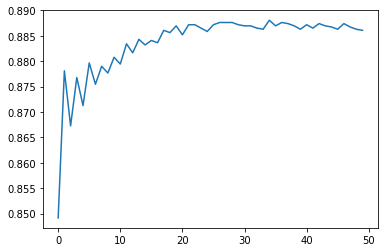

In [50]:
pd.Series(accuracy).plot()

<AxesSubplot:>

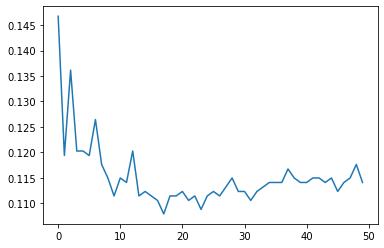

In [51]:
pd.Series(error_rate).plot()


As we can see from the above two graphs for accuracy and errors, there is significant effect of value of k on accuracy and error only upto a point, i.e., till k=10. Beyond that there is smaller differences, which is not so significant. we have the best accuracy at k=34, it is 88.8.  However at k=10 it is 88.07 ~ 88.1.It is better to have almost the same accuracy with lower value of k, it reduces the cost of the model. to achieve 88.1 at k=10 is better than achieving 88.8 at k=34 wrt cost.

### Naive Bayes

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable

#### Naive Bayes GaussianNB

In [52]:
clf_gaussian = make_pipeline(trf_preproc,GaussianNB())
clf_gaussian.fit(X_train, y_train)
y_pred_gaussian = clf_gaussian.predict(X_test)

In [53]:
print("Accuracy for random forest:",metrics.accuracy_score(y_test, y_pred_gaussian))

Accuracy for random forest: 0.8576480990274093


#### With 10 fold cross validation for GaussianNB

In [54]:
cv_result = cross_val_score(clf_gaussian,X,y, cv = kfold,scoring = "accuracy")
print("Value for k from 1 to 10 : ",cv_result)
print("Mean Accuracy from 10 fold cross validation:",cv_result.mean())

Value for k from 1 to 10 :  [0.86313466 0.84070796 0.83185841 0.84070796 0.84734513 0.86725664
 0.82079646 0.80973451 0.8539823  0.84734513]
Mean Accuracy from 10 fold cross validation: 0.842286917111098


#### Naive Bayes MultinomialNB

In [55]:
clf_multinomial = make_pipeline(trf_preproc, MultinomialNB())
clf_multinomial.fit(X_train, y_train)
y_pred_multi = clf_multinomial.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_multi))

Accuracy: 0.8850574712643678


#### With 10 fold cross validation for MultinomialNB

In [56]:
cv_result_multi = cross_val_score(clf_multinomial,X,y, cv = kfold,scoring = "accuracy")
print("Value for k from 1 to 10 : ",cv_result_multi)
print("Mean Accuracy from 10 fold cross validation:",cv_result_multi.mean())

Value for k from 1 to 10 :  [0.88300221 0.88495575 0.88495575 0.88495575 0.88495575 0.88495575
 0.88495575 0.88495575 0.88495575 0.88495575]
Mean Accuracy from 10 fold cross validation: 0.8847603977417025



##### Multi nominalNB is better than the GaussianNB model,it has higher accuracy

### Conclusion
Below is the table showing the accuracy and 10 fold cross validation accuracy for each of the models given



 Model  | Accuracy| 10-fold-cross-validation_accuracy  | 
------------- | -------------| ------------- | 
Decision Tree  | 85.86 | 86.20  | 
Random Forest  | 90.27 | 90.07  | 
KNN   | 88.86 | 88.08  | 
GaussianNB  | 85.76 | 84.23  | 
MultinomialNB  | 88.50 | 88.48  | 


##### Random forest performs the best among all the above models giving 90% accuracy. 
##### KNN and multinomial Naive Bayes are performing better after Random forest at around 88% accuracy.